In [328]:
# Description : The project aims at predicting payment date or invoice clear date

In [329]:
# Imports
from forex_python.converter import CurrencyRates
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import  matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

## READING DATA 

In [330]:
# Loading Data
raw = pd.read_csv(r'H2HBABBA3195.csv')

In [331]:
raw.shape

(50000, 19)

In [332]:
# Overview of Data
raw.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200779906,BOZZU corporation,2019-03-28 00:00:00,2019.0,1.928941e+09,2019-03-12,20190310,20190312,20190327.0,USD,RV,1.0,NaN,44468.83,20190312.0,NAA8,1.928941e+09,0
1,U001,0200769623,WAL-MAR associates,2019-04-03 00:00:00,2019.0,1.929015e+09,2019-03-24,20190323,20190324,20190408.0,USD,RV,1.0,NaN,4013.75,20190324.0,NAH4,1.929015e+09,0
2,U001,0200772670,ASSOCIAT corp,2019-05-22 00:00:00,2019.0,1.929268e+09,2019-05-06,20190506,20190506,20190521.0,USD,RV,1.0,NaN,77909.09,20190506.0,NAU5,1.929268e+09,0
3,U001,0100044041,DEF. F co,2020-03-02 00:00:00,2020.0,1.930548e+09,2020-02-20,20200220,20200220,20200310.0,USD,RV,1.0,NaN,2459.37,20200216.0,NAM4,1.930548e+09,0
4,U001,0200705742,DOT corporation,2019-05-15 00:00:00,2019.0,1.929234e+09,2019-04-30,20190430,20190430,20190603.0,USD,RV,1.0,NaN,10073.68,20190430.0,NAAW,1.929234e+09,0


In [333]:
raw.dtypes

business_code              object
cust_number                object
name_customer              object
clear_date                 object
buisness_year             float64
doc_id                    float64
posting_date               object
document_create_date        int64
document_create_date.1      int64
due_in_date               float64
invoice_currency           object
document type              object
posting_id                float64
area_business             float64
total_open_amount         float64
baseline_create_date      float64
cust_payment_terms         object
invoice_id                float64
isOpen                      int64
dtype: object

In [334]:
raw.nunique(axis=0)

business_code                 6
cust_number                1394
name_customer              4195
clear_date                  402
buisness_year                 2
doc_id                    48806
posting_date                507
document_create_date        509
document_create_date.1      507
due_in_date                 545
invoice_currency              2
document type                 2
posting_id                    1
area_business                 0
total_open_amount         44262
baseline_create_date        509
cust_payment_terms           75
invoice_id                48802
isOpen                        2
dtype: int64

## PREPROCESSING THE DATA

### PARSING DATES

In [335]:
# converting dates into appropriate format

def convert_to_date(df,attribute,general=True):
    if(general):
        df[attribute] = pd.to_datetime(df[attribute])
    else:
        df[attribute] = pd.to_datetime(df[attribute],format='%Y%m%d')     
        
convert_to_date(raw,'clear_date',True)
convert_to_date(raw,'posting_date',True)
convert_to_date(raw,'document_create_date',False)
convert_to_date(raw,'document_create_date.1',False)
convert_to_date(raw,'baseline_create_date',False)
convert_to_date(raw,'due_in_date',False)

### REMOVING CONSTANT COLUMNS

In [336]:
# as inferred from the nunique function 
# posting_id is constant column and area_business is NULL column

raw.drop(['posting_id','area_business'],axis=1,inplace=True)

### NULL IMPUTATION

In [337]:
raw.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    4
isOpen                        0
dtype: int64

In [338]:
# as there are only 4 NULL in only invoice_id 
# which is approximately 0.008% of the whole data
# also as according to data dictionary invoice_id is the unique no that identifies an invoice 
# hence can be dropped

raw[raw.invoice_id.isnull()]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
8544,CA02,0140106054,TREE corporation,2019-06-17,2019.0,9.500000e+09,2019-03-29,2019-03-29,2019-03-22,2019-04-01,CAD,X2,25215.84,2019-03-22,CA10,NaN,0
10368,CA02,0140104409,LOB foundation,2019-05-08,2019.0,9.500000e+09,2019-03-29,2019-03-29,2019-02-24,2019-03-06,CAD,X2,16505.64,2019-02-24,CA10,NaN,0
14733,CA02,0100054173,DIA associates,2019-05-31,2019.0,9.500000e+09,2019-03-29,2019-03-29,2019-01-23,2019-02-02,CAD,X2,31200.00,2019-01-23,CA10,NaN,0
47316,CA02,0140104429,COSTCO corp,2019-05-02,2019.0,9.500000e+09,2019-03-29,2019-03-29,2019-02-19,2019-03-01,CAD,X2,5353.20,2019-02-19,CA10,NaN,0


In [339]:
raw = raw[raw.invoice_id.isnull()==False]

In [340]:
raw['cust_number'] = raw['cust_number'].astype(str)

### CHECK FOR DUPLICATE ROWS

In [341]:
#raw[raw.duplicated()]

In [342]:
# Infering from the above output its clear that the rows where clear_date is NULL should be used as FINAL_TEST_SET
# Separaring FINAL_TEST_SET from MAIN_SET

final_test = raw[raw.clear_date.isnull()]
main_set = raw[raw.clear_date.isnull()==False] 

### TARGET VARIABLE

In [343]:
# for a regression based model its not easy to predict payment date straight away
# hence choosing delay of no of days as target

def create_target_variable(data_frame):
#     data_frame['target'] = (data_frame['clear_date'] - data_frame['baseline_create_date']).dt.days
    data_frame['target'] = (data_frame['clear_date'] - data_frame['due_in_date']).dt.days
    data_frame.drop('clear_date',axis=1,inplace=True)
    
create_target_variable(final_test)
create_target_variable(main_set)

## TRAIN TEST VALIDATION SPLIT

In [344]:
# Splitting at this point is important so as to avoid any target data leekage
# we are working with time series, hence its necessary to sort the data according to time
# as in any case we won't be predecting any past date

main_set.sort_values(by=['document_create_date'])

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,target
33189,U013,0140103335,PARAM associates,2019.0,1.991819e+09,2018-12-30,2018-12-26,2018-12-30,2019-01-29,USD,RV,10045.23,2018-12-30,NAVE,1.991819e+09,0,-6
19741,U001,0200726979,BJ'S systems,2019.0,1.928541e+09,2018-12-31,2018-12-29,2018-12-31,2019-01-15,USD,RV,385.51,2018-12-31,NAA8,1.928541e+09,0,0
2331,U001,0200769623,WAL-MAR llc,2019.0,1.928542e+09,2018-12-31,2018-12-29,2018-12-31,2019-01-15,USD,RV,46621.22,2018-12-31,NAH4,1.928542e+09,0,-5
34102,U001,0200769623,WAL-MAR systems,2019.0,1.928542e+09,2018-12-30,2018-12-29,2018-12-30,2019-01-14,USD,RV,23894.36,2018-12-30,NAH4,1.928542e+09,0,-3
5902,U001,0200515231,US in,2019.0,1.928533e+09,2019-01-03,2018-12-29,2019-01-03,2019-01-23,USD,RV,20434.39,2019-01-03,NAD1,1.928533e+09,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23795,U001,0200936373,SUPE llc,2020.0,1.930577e+09,2020-02-26,2020-02-27,2020-02-26,2020-03-12,USD,RV,277.06,2020-02-26,NAA8,1.930577e+09,0,1
7808,U001,0200762301,C&S WH,2020.0,1.930576e+09,2020-02-26,2020-02-27,2020-02-26,2020-03-12,USD,RV,62774.35,2020-02-26,NAC6,1.930576e+09,0,0
28808,U001,CCU013,KRAFT F co,2020.0,1.930582e+09,2020-02-19,2020-02-28,2020-02-19,2020-02-19,USD,RV,18768.00,2020-02-19,NAX2,1.930582e+09,0,37
29507,U001,0200895843,US associates,2020.0,1.930581e+09,2020-02-27,2020-02-28,2020-02-27,2020-03-13,USD,RV,35655.90,2020-02-27,NAA8,1.930581e+09,0,0


In [345]:
X = main_set.drop('target',axis=1)
Y = main_set['target']

In [346]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0,shuffle = False)

In [347]:
X_main_train,X_val,Y_main_train,Y_val = train_test_split(X_train,Y_train,test_size=0.2,random_state=0,shuffle = False)

In [348]:
# Now we have four sets of data
# 1. final_set
# 2. X_test       -- Y_test
# 3. X_val        -- Y_val
# 4. X_main_train -- Y_main_train

X_main_train.shape ,X_test.shape ,X_val.shape

((25596, 16), (8000, 16), (6400, 16))

## EDA AND OUTLIERS

<AxesSubplot:xlabel='target', ylabel='Density'>

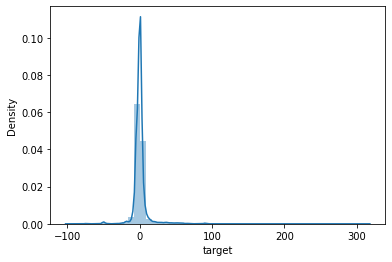

In [349]:
sns.distplot(Y_main_train)

<AxesSubplot:xlabel='total_open_amount', ylabel='target'>

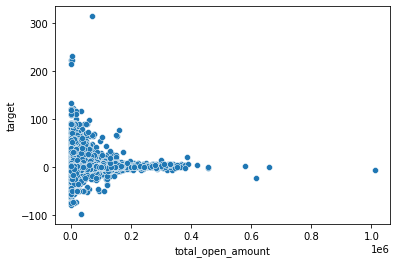

In [350]:
sns.scatterplot(data=X_main_train.merge(Y_main_train,on = X_main_train.index), x="total_open_amount", y="target")

<AxesSubplot:xlabel='target'>

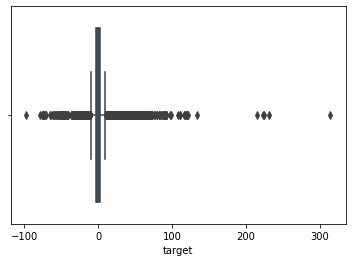

In [351]:
sns.boxplot(Y_main_train)

In [352]:
Q1 = np.percentile(Y_main_train, 1, interpolation = 'midpoint') 
Q2 = np.percentile(Y_main_train, 50, interpolation = 'midpoint') 
Q3 = np.percentile(Y_main_train, 99, interpolation = 'midpoint') 
  
print('Q1 25 percentile of the given data is, ', Q1)
print('Q1 50 percentile of the given data is, ', Q2)
print('Q1 75 percentile of the given data is, ', Q3)
  
IQR = Q3 - Q1 
print('Interquartile range is', IQR)

Q1 25 percentile of the given data is,  -22.0
Q1 50 percentile of the given data is,  0.0
Q1 75 percentile of the given data is,  49.0
Interquartile range is 71.0


In [353]:
low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR
print('low_limit is', low_lim)
print('up_limit is', up_lim)

low_limit is -128.5
up_limit is 155.5


In [354]:
outlier =[]
for x in Y_main_train:
    if ((x> up_lim) or (x<low_lim)):
         outlier.append(x)
print(' outlier in the dataset is', len(outlier))

 outlier in the dataset is 5


In [355]:
from scipy import stats
IQR = stats.iqr(Y_main_train, interpolation = 'midpoint')
IQR

5.0

## FEATURE ENGINEERING

In [356]:
# X_main_train

In [357]:
X_main_train['business_code'].value_counts()

U001    23227
CA02     1958
U013      328
U002       76
U005        7
Name: business_code, dtype: int64

In [358]:
X_main_train['cust_payment_terms'].value_counts()

NAA8    10161
NAH4     6842
CA10     1889
NAC6      859
NAM4      733
NAAX      610
NAD1      516
NAG2      476
NAU5      452
NA32      420
NAGD      400
NAX2      374
NAM2      283
NA10      219
NAD5      194
NAM1      153
NAVE      146
NAVF      133
NAAW      112
NAWU       87
NAVR       74
NAVQ       61
NAWN       60
NAWP       46
NAVM       29
CA30       27
NACB       26
NAUZ       25
NA3B       23
NABG       17
NA38       17
C106       12
NAVL       11
NAVD        9
NA3F        9
NAD4        9
NA9X        8
NAB1        8
BR56        6
NA8Q        6
NAUP        5
NA84        4
NA25        4
BR12        4
NAWM        3
NAD8        3
B052        3
CAB1        3
NAM3        3
NAUN        3
NATK        1
NAUX        1
NA31        1
NATJ        1
NANC        1
NAV9        1
NAUI        1
B112        1
NATH        1
NAV2        1
NATM        1
NATW        1
NAVC        1
CA60        1
NATZ        1
90M7        1
NATL        1
CAX2        1
NACE        1
Name: cust_payment_terms, dtype: i

In [359]:
X_main_train['document type'].value_counts()

RV    25596
Name: document type, dtype: int64

In [360]:
X_main_train['isOpen'].value_counts()

0    25596
Name: isOpen, dtype: int64

In [361]:
pd. set_option('display.max_rows', 3000) # or 1000.
X_main_train['cust_number'].value_counts()

0200769623    5806
0200726979    1002
0200762301     749
0200759878     691
0200794332     564
0200744019     512
0200772670     446
0200705742     446
200769623      389
CCU013         373
0200707822     321
CCCA02         286
0140106408     274
0140104409     249
0200418007     249
0200803720     235
0200780383     234
0100031704     220
0140104429     198
0200416837     197
0200230690     192
0200353024     191
0200799367     190
0200706844     184
0200761734     179
0200020431     161
0200772595     160
0200148860     158
0200936373     151
0200704858     149
0200793568     142
0140104440     139
0200974851     138
0140105686     134
0200729942     126
0200714710     118
0200764795     109
0200782001     107
0200592182     107
0200704045     105
0140104423     101
0200752302     100
0200792734      98
0200900909      97
0200739534      90
0200777735      90
0200782669      88
0200152991      88
0200781803      88
0200763814      86
0200718130      85
CCU002          85
0200331749  

In [362]:
class Encoder:
    def __init__(self,main_list):
        self.main_list = np.append(main_list,['OTHR'])
        self.encoder = LabelEncoder()
        self.encoder.fit(self.main_list)
        
    def encode(self,data):
        data = np.where(data.isin(self.main_list),data,'OTHR')
        data = self.encoder.transform(data)
        return data

In [363]:
# Business_code_encoder = Encoder(np.array(['U001','CA02','U013']))

# X_main_train['business_code'] = Business_code_encoder.encode(X_main_train['business_code'])
# X_test['business_code'] = Business_code_encoder.encode(X_test['business_code'])
# X_val['business_code'] = Business_code_encoder.encode(X_val['business_code'])

In [364]:
# main_cat = get_subarray_freq(X_main_train['cust_payment_terms'],5)
# Customer_payterms_encoder = Encoder(main_cat)

# X_main_train['cust_payment_terms'] = Customer_payterms_encoder.encode(X_main_train['cust_payment_terms'])
# X_test['cust_payment_terms'] = Customer_payterms_encoder.encode(X_test['cust_payment_terms'])
# X_val['cust_payment_terms'] = Customer_payterms_encoder.encode(X_val['cust_payment_terms'])

In [365]:
# Helper function 
def get_subarray_freq(arr,frequency):    
    (unique, counts) = np.unique(arr, return_counts=True)
    final = []
    for x in range(len(unique)):
        if(counts[x]>=5):
            final.append(unique[x])
    final = np.array(final)
    return final

In [366]:
# Handling Business_code
major_business_code = get_subarray_freq(X_main_train['business_code'],328)
major_business_code = np.append(major_business_code,'OTHR')
print(major_business_code)

business_code_en = LabelEncoder()
business_code_en.fit(major_business_code)

def handle_business_code(df):
    df['business_code'] = np.where(df['business_code'].isin(['U001','CA02','U013']),df['business_code'],'OTHR')
    df['business_code'] = business_code_en.transform(df['business_code'])
    
handle_business_code(X_main_train)
handle_business_code(X_test)
handle_business_code(X_val)

['CA02' 'U001' 'U002' 'U005' 'U013' 'OTHR']


In [367]:
# Handling Customer_no
major_customer = get_subarray_freq(X_main_train['cust_number'],328)
major_customer = np.append(major_customer,'OTHR')

# print(major_customer)

cust_number_en = LabelEncoder()
cust_number_en.fit(major_customer)

def handle_customer_number(df):
    df['cust_number'] = np.where(df['cust_number'].isin(major_customer),df['cust_number'],'OTHR')
    df['cust_number'] = cust_number_en.transform(df['cust_number'])
    
handle_customer_number(X_main_train)
handle_customer_number(X_test)
handle_customer_number(X_val)

In [368]:
# Handling Cust_payment_terms
major_cat = get_subarray_freq(X_main_train['cust_payment_terms'],5)
major_cat = np.append(major_cat,'OTHR')

cust_payment_terms_en = LabelEncoder()
cust_payment_terms_en.fit(major_cat)

def handle_cust_payment_terms(df):
    df['cust_payment_terms'] = np.where(df['cust_payment_terms'].isin(major_cat),df['cust_payment_terms'],'OTHR')
    df['cust_payment_terms'] = cust_payment_terms_en.transform(df['cust_payment_terms'])
    
handle_cust_payment_terms(X_main_train)
handle_cust_payment_terms(X_test)
handle_cust_payment_terms(X_val)

In [369]:
# Handling total_open_amount
min_date = raw['baseline_create_date'].min()
max_date = raw['baseline_create_date'].max()
all_dates = np.arange(min_date,max_date, dtype='datetime64[D]')
print(min_date,max_date)
print(all_dates.shape)
# c = CurrencyRates()
# c.convert('USD','INR',1, min_date)
average_rate = 0.81

def handle_date(df):
    df['total_open_amount'] = np.where(df['invoice_currency'].isin(['USD']),df['total_open_amount'],df['total_open_amount']*average_rate)

handle_date(X_main_train)
handle_date(X_test)
handle_date(X_val)

2018-12-13 00:00:00 2020-05-22 00:00:00
(526,)


In [370]:
# Handling invoice_currency
currency_type = X_main_train['invoice_currency'].unique()
invoice_currency_en = LabelEncoder()
cust_payment_terms_en.fit(currency_type)

def handle_cust_payment_terms(df):
    df['invoice_currency'] = cust_payment_terms_en.transform(df['invoice_currency'])
    
handle_cust_payment_terms(X_main_train)
handle_cust_payment_terms(X_test)
handle_cust_payment_terms(X_val)


In [371]:
# Handling document type

def handle_doc_type(df):
    df.drop(['document type'],axis=1,inplace=True)
    
handle_doc_type(X_main_train)
handle_doc_type(X_test)
handle_doc_type(X_val)

In [372]:
# Handling is_open

def handle_is_open(df):
    df.drop(['isOpen'],axis=1,inplace=True)
    
handle_is_open(X_main_train)
handle_is_open(X_test)
handle_is_open(X_val)    

In [373]:
# Handling name_customer

def handle_name(df):
    df.drop(['name_customer'],axis=1,inplace=True)
    
handle_name(X_main_train)
handle_name(X_test)
handle_name(X_val)    

In [374]:
# Handling buisness_year

def handle_buisness_year(df):
    df.drop(['buisness_year'],axis=1,inplace=True)
    
handle_buisness_year(X_main_train)
handle_buisness_year(X_test)
handle_buisness_year(X_val)

In [375]:
# Handling buisness_year

def handle_invoice_id(df):
    df.drop(['invoice_id'],axis=1,inplace=True)
    
handle_invoice_id(X_main_train)
handle_invoice_id(X_test)
handle_invoice_id(X_val)

In [376]:
# Handling doc_id

def handle_doc_id(df):
    df.drop(['doc_id'],axis=1,inplace=True)
    
handle_doc_id(X_main_train)
handle_doc_id(X_test)
handle_doc_id(X_val)

In [377]:
# Handling unwanted_dates

def handle_unwanted_dates(df):
    df.drop(['document_create_date','document_create_date.1'],axis=1,inplace=True)
    
handle_unwanted_dates(X_main_train)
handle_unwanted_dates(X_test)
handle_unwanted_dates(X_val)

In [378]:
# Making some more features using dates
def make_expected_days(df):
    df['expected'] = (df['due_in_date'] - df['posting_date']).dt.days
    
make_expected_days(X_main_train)
make_expected_days(X_test)
make_expected_days(X_val)

In [379]:
def make_day_and_month(df):
    df['day_of_week_post'] = df['posting_date'].dt.weekday
    df['month_post'] = df['posting_date'].dt.month
    
    df['day_of_week_due'] = df['due_in_date'].dt.weekday
    df['month_due'] = df['due_in_date'].dt.month
    
make_day_and_month(X_main_train)
make_day_and_month(X_test)
make_day_and_month(X_val)

In [380]:
def drop_all_dates(df):
    df.drop(['posting_date','due_in_date','baseline_create_date'],axis=1,inplace=True)

drop_all_dates(X_main_train)
drop_all_dates(X_test)
drop_all_dates(X_val)

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

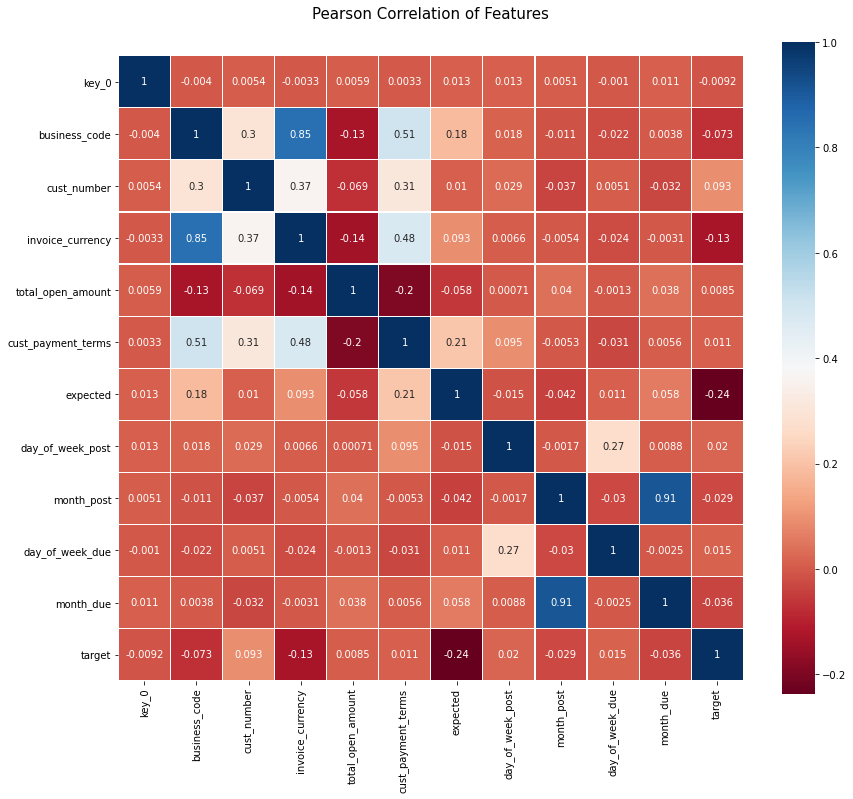

In [381]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_main_train.merge(Y_main_train , on = X_main_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [382]:
X_main_train.head(5)

,business_code,cust_number,invoice_currency,total_open_amount,cust_payment_terms,expected,day_of_week_post,month_post,day_of_week_due,month_due
0,2,285,1,44468.83,11,15,1,3,2,3
1,2,268,1,4013.75,23,15,6,3,0,4
2,2,273,1,77909.09,27,15,0,5,1,5
3,2,44,1,2459.37,26,19,3,2,1,3
4,2,184,1,10073.68,12,34,1,4,0,6


## MODELING

In [383]:
base_model = LinearRegression()
base_model.fit(X_main_train, Y_main_train)

LinearRegression()

In [384]:
y_predict = base_model.predict(X_test)

In [385]:
mean_squared_error(Y_test, y_predict, squared=False)

9.910401373419596

In [386]:
regressor = DecisionTreeRegressor(random_state=0 , max_depth=9)
regressor.fit(X_main_train, Y_main_train)

DecisionTreeRegressor(max_depth=9, random_state=0)

In [387]:
y_predict2 = regressor.predict(X_test)

In [388]:
mean_squared_error(Y_test, y_predict2, squared=False)

7.6753089869543425

In [389]:
regr = RandomForestRegressor(max_depth=12, random_state=0)
regr.fit(X_main_train, Y_main_train)

RandomForestRegressor(max_depth=12, random_state=0)

In [390]:
y_predict3 = regr.predict(X_test)

In [391]:
mean_squared_error(Y_test, y_predict3, squared=False)

7.459657520343051